**DEMO OF standard gridder**

In [1]:
import numpy as np
from matplotlib import pylab as pl
from astroviper.core.imaging.imaging_utils.standard_grid import *
from astroviper.core.imaging.imaging_utils.gcf_prolate_spheroidal import *
from astroviper.core.imaging.fft import fft_lm_to_uv
from astroviper.core.imaging.ifft import ifft_uv_to_lm


In [2]:
from astroviper.core.imaging.imaging_utils.standard_gridding_example import generate_ms4_with_point_sources

Lets generate a ms4 dataArray with a few point sources in it

_sources_ will have the position and flux of source, _npix_ is the size of the image you may wish to make, _cell_ the cellsize determined from max uv and _ms4_ will be an xradio msv4 dataArray
Here we are putting 4 point sources of 1 Jy visibilities

In [3]:
nsources = 4
sources, npix, cell, ms4 = generate_ms4_with_point_sources(nsources, np.ones(nsources))

Initialize some gridding parameters. Most are taken from the meta data info of the _ms4_
we'll use a prolate spheroidal function overampled by 100 and having a support of 7 pixels

In [4]:
support=7
oversampling=100
#conv func
cgk_1D = create_prolate_spheroidal_kernel_1D(oversampling, support)
vis_data=ms4.VISIBILITY.data
uvw=ms4.UVW.data
#We will initialize all the weights to 1
dims = ms4.dims
weight = np.ones([dims["time"], dims["baseline_id"], dims["frequency"], 1])
freq_chan = ms4.coords["frequency"].values
image_size=np.array([npix, npix])
cell_size= np.array([cell.to("rad").value, cell.to("rad").value])
complex_grid=True
do_psf=False
chan_mode="continuum"

Now we call the gridding code; it returns the complex grid and sumweights

In [5]:
grid, sumwt = standard_grid_numpy_wrap_input_checked(
            vis_data=vis_data,
            uvw=uvw,
            weight=weight,
            freq_chan=freq_chan,
            cgk_1D=cgk_1D,
            image_size=image_size,
            cell_size=cell_size,
            oversampling=oversampling,
            support=support,
            complex_grid=complex_grid,
            do_psf=do_psf,
            chan_mode=chan_mode
        )

Now FFT back to image domain and correct for the convolution function

In [6]:
kernel, corrTerm = create_prolate_spheroidal_kernel(
            oversampling, support, image_size)
dirty_im = (
            ifft_uv_to_lm(grid, axes=[2, 3])
            / corrTerm
            * image_size[0]
            * image_size[1]
            / sumwt
        )

locate the sources and compare to what was simulated in 

In [7]:
pos_peaks=np.where(dirty_im[0,0,:,:] > 0.9)

In [8]:
for posy, posx in zip(pos_peaks[0], pos_peaks[1]):
    print(f'source found at [{posy, posx}] has value of {dirty_im[0,0, posy, posx]}')

source found at [(np.int64(107), np.int64(89))] has value of 0.9539283466457885
source found at [(np.int64(111), np.int64(85))] has value of 0.9000337060924987
source found at [(np.int64(122), np.int64(123))] has value of 0.9357788272760021
source found at [(np.int64(123), np.int64(89))] has value of 0.9084140158961516


In [9]:
for k in range(len(sources[0])):
    print(f'Simulated source at [{sources[0][k], sources[1][k]}] has value of {sources[2][k]}')

Simulated source at [(np.int64(111), np.int64(85))] has value of 1.0
Simulated source at [(np.int64(123), np.int64(89))] has value of 1.0
Simulated source at [(np.int64(107), np.int64(89))] has value of 1.0
Simulated source at [(np.int64(122), np.int64(123))] has value of 1.0


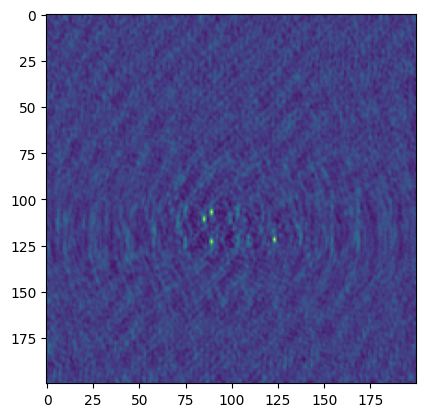

In [10]:
pl.imshow(dirty_im[0,0,:,:])